In [1]:
using Plots
using QuadGK
using LinearAlgebra

$$
f(x)=\frac{1}{\sqrt{2 \pi \sigma^{2}}} \exp \left(-\frac{(x-\mu)^{2}}{2 \sigma^{2}}\right) \quad(x \in \mathbb{R})
$$

In [2]:
aomega(omega) = 1/3 * ( exp(-0.5 * (omega/0.1)^2)/sqrt(2*π*0.1^2) + exp(-0.5 * (omega+5)^2)/sqrt(2*π) + exp(-0.5 * (omega-5)^2)/sqrt(2*π))

aomega (generic function with 1 method)

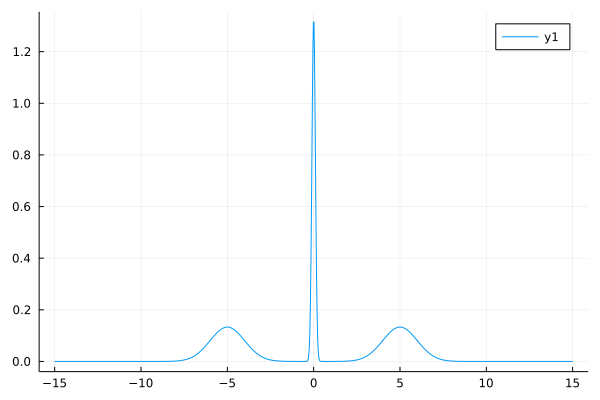

In [119]:
wmax = 15
omegas = LinRange(-wmax, wmax, 1000)
plot(omegas, aomega.(omegas))

In [120]:
c = quadgk(x -> aomega(x), -wmax, wmax)[1]
println("normalize=", quadgk(x -> aomega(x), -wmax, wmax)[1])


normalize=1.0000000000000002


# particle

$$
T^{(n)}_p = (-1)^{n+1} \frac{d^n G(\tau)}{d\tau^n} \mid_{\tau=0^+}
$$

$$
T^{(n)}_h = (-1)^{n} \frac{d^n G(\tau)}{d\tau^n} \mid_{\tau=0^+}
$$

$$
S_n = T[0]^{-1/2} T[n] T[0]^{-1/2}
$$

In [121]:
nmom = 13
Tp = Float64[]
for mom in 0:(nmom-1)
    push!(Tp, quadgk(x -> (x^mom) * aomega(x), 0, wmax)[1])
end
Tp

13-element Vector{Float64}:
      0.5
      1.6799647783211518
      8.668333333333333
     46.666932634991504
    259.33338333331045
   1483.333344040773
   8713.333335848516
  52466.66666730899
 323326.6666668398
      2.0363666666667233e6
      1.3091773333333328e7
      8.582253333333334e7
      5.731221733333335e8

In [122]:
function reconst(T)
    nmom = length(T)
    S = (1/sqrt(T[1])) * T * (1/sqrt(T[1]))
    println(S)

    As = Dict{Int,ComplexF64}()
    Bs = Dict{Int,ComplexF64}()
    Cs = Dict{Tuple{Int,Int},ComplexF64}()

    # Initial values
    As[0] = S[2]
    Bs[0] = 0.0
    Cs[0,0] = 1.0

    function get_S(i)
        i <= nmom-1 ? S[i+1] : 0.0
    end
    
    function get_Cs(n, j)::ComplexF64
        if j < 0 || j > n || n < 0
            return 0.0
        end
        return Cs[(n, j)]
    end

    for n in 0:nmom
        #println("n = $n")
        # Update B[n+1]
        bfirst = sum(conj(Cs[n,l]) * get_S(j+l+1) * get_Cs(n, j-1) for j in 0:(n+1), l in 0:n)
        Bs[n+1] = sqrt(bfirst  - As[n]^2  - conj(Bs[n]^2))

        # C(n+1, j) for j = 0, ..., n+1 (otherwise 0)
        for j in 0:(n+1)
            Cs[(n+1, j)] = (get_Cs(n, j-1) - get_Cs(n, j) * As[n] - get_Cs(n-1, j) * conj(Bs[n])) / Bs[n+1]
        end

        # Update A[n+1]
        As[n+1] = sum(conj(get_Cs(n+1, l) * get_S(j+l+1) * get_Cs(n+1, j)) for j in 0:(n+1), l in 0:(n+1))

        if length(As) >= (nmom + 1) ÷ 2
            break
        end
    end
    return  As, Bs
end

As, Bs = reconst(Tp)


[0.9999999999999998, 3.359929556642303, 17.336666666666662, 93.333865269983, 518.6667666666208, 2966.666688081545, 17426.66667169703, 104933.33333461796, 646653.3333336795, 4.072733333333446e6, 2.6183546666666653e7, 1.7164506666666666e8, 1.1462443466666667e9]


(Dict{Int64, ComplexF64}(0 => 3.359929556642303 + 0.0im, 4 => 4.631725401006406 + 0.0im, 5 => 3.877896915335441 + 0.0im, 6 => -1.6360499244350856e6 + 0.0im, 2 => 5.1008719491738646 + 0.0im, 3 => 5.291366109136561 + 0.0im, 1 => 2.441418807278202 + 0.0im), Dict{Int64, ComplexF64}(0 => 0.0 + 0.0im, 4 => 1.8356331320757224 + 0.0im, 5 => 2.5815196542557715 + 0.0im, 6 => 2.68640337054449 + 0.0im, 2 => 1.5523288662643753 + 0.0im, 3 => 1.4200085843179309 + 0.0im, 1 => 2.459174666644913 + 0.0im))

In [123]:
nc = length(As)
htri = zeros(ComplexF64, nc, nc)
for i in 1:nc
    htri[i, i] = As[i-1]
end
for i in 1:(nc-1)
    htri[i, i+1] = Bs[i]
    htri[i+1, i] = conj(Bs[i])
end

htri

7×7 Matrix{ComplexF64}:
 3.35993+0.0im  2.45917+0.0im  …      0.0+0.0im         0.0+0.0im
 2.45917-0.0im  2.44142+0.0im         0.0+0.0im         0.0+0.0im
     0.0+0.0im  1.55233-0.0im         0.0+0.0im         0.0+0.0im
     0.0+0.0im      0.0+0.0im         0.0+0.0im         0.0+0.0im
     0.0+0.0im      0.0+0.0im     2.58152+0.0im         0.0+0.0im
     0.0+0.0im      0.0+0.0im  …   3.8779+0.0im      2.6864+0.0im
     0.0+0.0im      0.0+0.0im      2.6864-0.0im  -1.63605e6+0.0im

In [124]:
e = eigen(Hermitian(htri))

Eigen{ComplexF64, Float64, Matrix{ComplexF64}, Vector{Float64}}
values:
7-element Vector{Float64}:
 -1.6360499244394905e6
  0.07072400631037379
  1.2168355211167823
  3.7221821643588378
  5.145445206980851
  6.520821769207944
  8.027204481677318
vectors:
7×7 Matrix{ComplexF64}:
  3.59841e-36+0.0im   -0.573381-0.0im  …     0.342927-0.0im   0.0674569-0.0im
 -2.39397e-30-0.0im    0.766911+0.0im         0.44078-0.0im    0.128027-0.0im
  2.52309e-24+0.0im   -0.262874-0.0im        0.615077+0.0im    0.353818-0.0im
 -2.90696e-18-0.0im   0.0928163+0.0im        0.133199-0.0im    0.589186-0.0im
   2.5909e-12+0.0im  -0.0606202-0.0im       -0.386598-0.0im     0.60442+0.0im
    -1.642e-6-0.0im   0.0411045+0.0im  …    -0.377617-0.0im    0.376044-0.0im
          1.0+0.0im  6.74938e-8-0.0im     -6.20047e-7-0.0im  6.17463e-7-0.0im

In [125]:
weight = real.(conj.(e.vectors[1, :]) .* e.vectors[1, :])

7-element Vector{Float64}:
 1.2948561184084406e-71
 0.3287656230280159
 0.009465567248653977
 0.1790190046712187
 0.3606005819526567
 0.11759878532413613
 0.00455043777531873

In [126]:
sum(weight)

1.0000000000000002

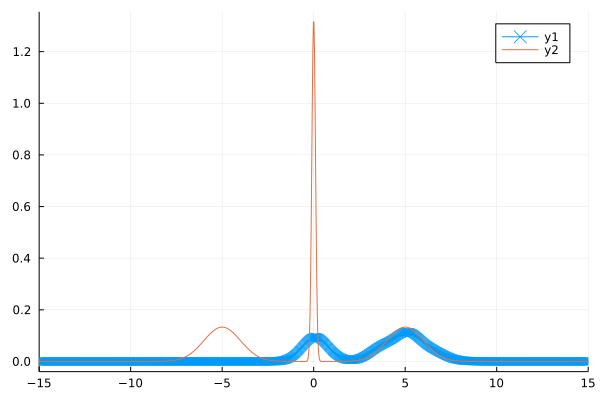

In [127]:
δ = 0.7
#p = 0.25
gaussian(x, μ) = exp(-0.5 * ((x-μ)/δ)^2)/(sqrt(2π) * δ)

cp = quadgk(x -> aomega(x), 0, wmax)[1]
aomega_reconst = zeros(Float64, length(omegas))
for ie in eachindex(e.values)
    aomega_reconst .+= cp * gaussian.(omegas, e.values[ie]) * weight[ie]
end

p = plot(xlim=(-wmax, wmax))
plot!(p, omegas, (aomega_reconst), xlim=(-wmax, wmax), marker=:x)
plot!(p, omegas, aomega.(omegas))

# hole

In [128]:

Th = Float64[]
for mom in 0:(nmom-1)
    push!(Th, quadgk(x -> (x^mom) * aomega(x), -wmax, 0)[1])
end
Th

13-element Vector{Float64}:
      0.5
     -1.6799647783211515
      8.668333333333331
    -46.666932634991504
    259.33338333331045
  -1483.333344040773
   8713.333335848516
 -52466.666667308986
 323326.66666683985
     -2.0363666666667233e6
      1.3091773333333328e7
     -8.582253333333337e7
      5.731221733333335e8

In [129]:
Ash, Bsh = reconst(Th)

[0.9999999999999998, -3.3599295566423026, 17.33666666666666, -93.333865269983, 518.6667666666208, -2966.666688081545, 17426.66667169703, -104933.33333461796, 646653.3333336796, -4.072733333333446e6, 2.6183546666666653e7, -1.7164506666666672e8, 1.1462443466666667e9]


(Dict{Int64, ComplexF64}(0 => -3.3599295566423026 + 0.0im, 4 => -4.631725400991854 + 0.0im, 5 => -3.877896913763834 + 0.0im, 6 => 1.636049921613194e6 + 0.0im, 2 => -5.100871949173921 + 0.0im, 3 => -5.29136610913838 + 0.0im, 1 => -2.4414188072782057 + 0.0im), Dict{Int64, ComplexF64}(0 => 0.0 + 0.0im, 4 => 1.8356331320675974 + 0.0im, 5 => 2.5815196544680403 + 0.0im, 6 => 2.686403372652501 + 0.0im, 2 => 1.5523288662643695 + 0.0im, 3 => 1.4200085843178134 + 0.0im, 1 => 2.459174666644913 + 0.0im))

In [130]:
nch = length(Ash)
htrih = zeros(ComplexF64, nc, nc)
for i in 1:nch
    htrih[i, i] = Ash[i-1]
end
for i in 1:(nch-1)
    htrih[i, i+1] = Bsh[i]
    htrih[i+1, i] = conj(Bsh[i])
end

htrih

7×7 Matrix{ComplexF64}:
 -3.35993+0.0im   2.45917+0.0im  …      0.0+0.0im        0.0+0.0im
  2.45917-0.0im  -2.44142+0.0im         0.0+0.0im        0.0+0.0im
      0.0+0.0im   1.55233-0.0im         0.0+0.0im        0.0+0.0im
      0.0+0.0im       0.0+0.0im         0.0+0.0im        0.0+0.0im
      0.0+0.0im       0.0+0.0im     2.58152+0.0im        0.0+0.0im
      0.0+0.0im       0.0+0.0im  …  -3.8779+0.0im     2.6864+0.0im
      0.0+0.0im       0.0+0.0im      2.6864-0.0im  1.63605e6+0.0im

In [131]:
eh = eigen(Hermitian(htrih))

Eigen{ComplexF64, Float64, Matrix{ComplexF64}, Vector{Float64}}
values:
7-element Vector{Float64}:
 -8.027204481541059
 -6.520821769044515
 -5.145445206785001
 -3.7221821641200075
 -1.2168355202705294
 -0.07072400630672604
  1.6360499216175987e6
vectors:
7×7 Matrix{ComplexF64}:
  0.0674569+0.0im     0.342927+0.0im      0.6005+0.0im  …  3.59841e-36-0.0im
  -0.128027-0.0im     -0.44078-0.0im   -0.436001-0.0im     2.39397e-30-0.0im
   0.353818+0.0im     0.615077+0.0im   -0.191826-0.0im     2.52309e-24-0.0im
  -0.589186-0.0im    -0.133199-0.0im     0.48265+0.0im     2.90696e-18-0.0im
    0.60442+0.0im    -0.386598-0.0im     0.18676-0.0im      2.5909e-12-0.0im
  -0.376044-0.0im     0.377617+0.0im   -0.380362-0.0im  …     1.642e-6-0.0im
 6.17463e-7+0.0im  -6.20047e-7-0.0im  6.24554e-7+0.0im             1.0+0.0im

In [132]:
weighth = real.(conj.(eh.vectors[1, :]) .* eh.vectors[1, :])

7-element Vector{Float64}:
 0.004550437777264273
 0.11759878535582739
 0.36060058197241923
 0.17901900462293918
 0.009465567247376896
 0.32876562302417295
 1.2948561474424986e-71

In [133]:
sum(weighth)

1.0

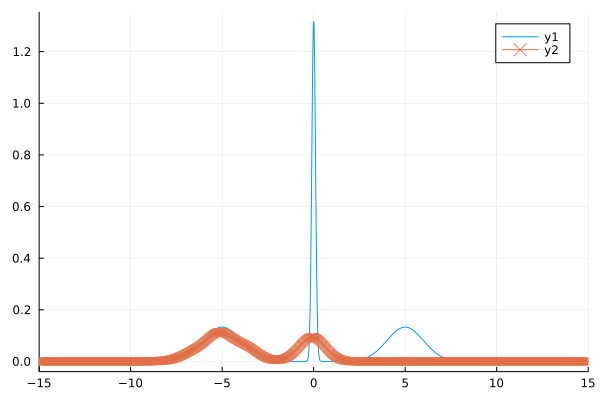

In [134]:
#hole
δh = 0.7
gaussianh(x, μh) = exp(-0.5 * ((x-μh)/δh)^2)/(sqrt(2π) * δh)

#hole
ch = quadgk(x -> aomega(x), -wmax, 0)[1]
aomega_reconsth = zeros(Float64, length(omegas))
for ieh in eachindex(eh.values)
    aomega_reconsth .+= ch * gaussianh.(omegas, eh.values[ieh]) * weighth[ieh]
end


p = plot(xlim=(-wmax, wmax))
plot!(p, omegas, aomega.(omegas))
plot!(p, omegas, (aomega_reconsth), xlim=(-wmax, wmax), marker=:x)

# whole picture

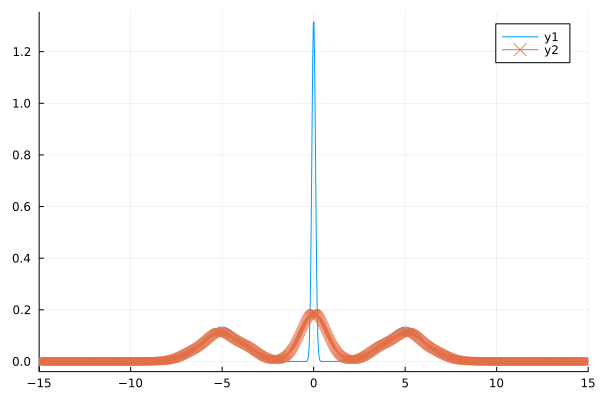

In [135]:
aomega_reconst_all = (aomega_reconst + aomega_reconsth)
#println(aomega_reconst_all)
p = plot(xlim=(-wmax, wmax))
plot!(p, omegas, aomega.(omegas))
plot!(p, omegas, (aomega_reconst_all), xlim=(-wmax, wmax), marker=:x)
#plot!(p, omegas, (aomega_reconsth),  xlim=(-wmax, wmax), maker=:x)


In [136]:
savefig("nmom=$(nmom)")